# Performing Photometry Using Astropy

This lab requires you to take the DES star images and do photometry on them. You will be given images of stars where you know the magnitude (calibration stars), and then you'll be given images of stars where you want to find the magnitude.

This notebook is a quick guide to how to find the average recorded counts and background counts using Astropy's photutils library. A quick outline of this notebook:

- import statements and a quick helper function
- importing the star data into the notebook 
- determining the size of your aperture and annulus
    - CircularAperature and CircularAnnulus objects
    - Graphing as a guess and check
- determining the background and data mean for your measurements

In [1]:
import numpy as np

from photutils import CircularAperture
from photutils import CircularAnnulus
from photutils import aperture_photometry
from astropy.io import fits

import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
from astropy.stats import mad_std

###### This plot_circle function will be useful when we plot the aperture and annulus of the objects...more on that later

In [2]:
def plot_circle(center, radius):
    x0, y0 = center
    x = [] ; y = []
    for i in range(2*314):
        x += [radius*np.cos(i/100) + x0]
        y += [radius*np.sin(i/100) + y0]
    return x, y

## Importing the Image and Getting Started

Once you have the star images downloaded onto JupyterHub, you can import them into your notebook. Importing FITS images works exactly like it did in the FITS file tutorial. 

In [3]:
image_path = "../data/star1/DES2334+0001_r2587p01_g_Y3A1_star_135459694_1.fits" #change per star
file = fits.open(image_path)

image = file[0]
image_data = image.data

## Determining the Size of your Aperture and Annulus

For this lab, we want to find the average pixel value for our star, and then we also want to find the average pixel value for the background so we can subtract the background later. In order to get an accurate reading for your star, you have to make sure that your "aperture" (which surrounds the star) isn't too big or too small; you generally want it right around the edge of the data. In order to get an accurate reading of the background, you want to make sure that you don't count any photons from your source, so your "annulus" (a ring around your source that measures background) should have an inner radius that is a little larger than the aperture. The best way to determine the sizes of the aperture and annulus is to guess and check. 

In [85]:
#The following code sets the center and size of the source and background apertures
#Take a guess for the center, source region, and inner and outer radii of the background region, and adjust as needed. 
x, y = image_data.shape
x /= 2 ; y /= 2 ; x-=.67 ; y -=.35 #play around with these numbers and see what changes
ap_radius = 3.5 #this is the radius of the aperture
an_radius_in = 6 ; an_radius_out = 9 # this is the inner and outer radius of the annulus
#keep apatures the same size if possible for same star in same band

In [86]:
x1, y1 = plot_circle((x, y), ap_radius)         # plot_circle will get the x and y coordinates of the circles
x2, y2 = plot_circle((x, y), an_radius_in)      # that we are making so we can graph them and check that the 
x3, y3 = plot_circle((x, y), an_radius_out)     # aperture and annulus are where they're supposed to be.

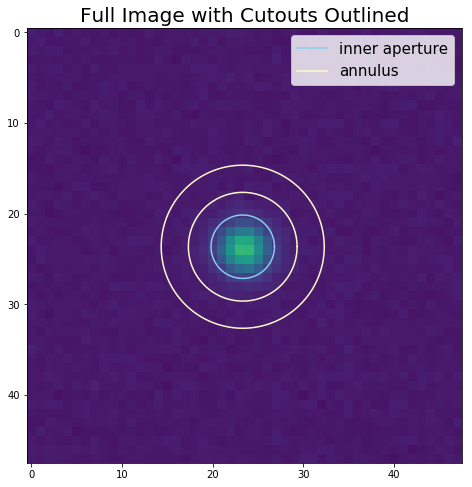

In [100]:
fig, axs = plt.subplots(1, 1, figsize=(8, 8))

plt.imshow(image_data, vmin=-1000, vmax=20000,)
plt.plot(x1, y1, color='skyblue', label="inner aperture")
plt.plot(x2, y2, color='lemonchiffon', label="annulus")
plt.plot(x3, y3, color='lemonchiffon')
plt.title("Full Image with Cutouts Outlined", fontsize=20)
plt.legend(fontsize=15)

#### For the default here you can see it is not quite centered right and the regions are too small.  Play around with these.
Now, we're going to actually create the aperture and annulus and double check that we have the right data. 

### CircularAperture and CircularAnnulus objects
On line 3 and 4 in the cell below, we instantiate a `CircularAperture` and `CircularAnnulus` object. These objects are useful because they allow us to easily create a mask. As we went over in the python refresher notebook, masks are boolean (true/false) arrays which we can apply to another array in order to only get the values we need. For example, if we have: 
```
mask = [True, False, False, False]
x = [2, 2, 2, 2]
print(x[mask])
>>> [2, 0, 0, 0]
```

This is useful in this notebook (and your lab) because we want the average value of a very specific range of values in our image, namely the range of values in the aperture and in the annulus. The `CircularAperture` and `CircularAnnulus` objects allow us to do just that with ease. 

Before we actually determine these averages, let's verify that these functions are doing what we want. 

In [88]:
positions = [(x, y)]

aperture = CircularAperture(positions, r=ap_radius)
annulus = CircularAnnulus(positions, r_in=an_radius_in, r_out=an_radius_out)

#get the data in the aperture (for plotting)
aperture_masks = aperture.to_mask()
aperture_data = aperture_masks[0].multiply(image_data)

#get the data in the annulus (for plotting)
annulus_masks = annulus.to_mask(method='center')
annulus_data = annulus_masks[0].multiply(image_data)

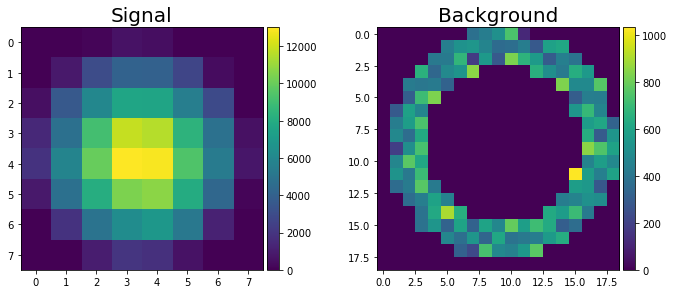

In [92]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 20))
im1=ax1.imshow(aperture_data)#, vmin=0, vmax=20000)
im2=ax2.imshow(annulus_data)#, vmin=0, vmax=20000)

divider1 = make_axes_locatable(ax1)
cax1 = divider1.append_axes("right", size="5%", pad=0.05)
ax1.set_title("Signal", fontsize=20)

divider2 = make_axes_locatable(ax2)
cax2 = divider2.append_axes("right", size="5%", pad=0.05)
ax2.set_title("Background", fontsize=20)

fig.colorbar(im1, ax=ax1, cax=cax1)
fig.colorbar(im2, ax=ax2, cax=cax2)
fig.tight_layout(pad=3.0)

This is exactly what we want. Notice the relative scaling of the colors for the background and the signal: the signal has a pixel count on the order to 20,000 while the background has a pixel count on the order of 800. This is what we expect. 

###### Everything is set up the way we want, so now let's get the data that we need. 

## Determining the Source and Background Counts
Now all we have to do is call photutil's `aperture_photometry` function, give it the image we want to analyze and the aperture/annulus we want to use, and this function will spit out a table of the total pixel count in the apertures. 

In [93]:
apers = [aperture, annulus]
phot_table = aperture_photometry(image_data, apers)

for col in phot_table.colnames:
    phot_table[col].info.format = '%.8g'  # for consistent table output
print(phot_table)

 id xcenter ycenter aperture_sum_0 aperture_sum_1
      pix     pix                                
--- ------- ------- -------------- --------------
  1   23.33   23.65      241852.76      74582.595


Now all we have to do is get the total counts in the source and background region, and the areas in pixels of the two regions.  We will also find the average background counts per pixel. 

In [101]:
bkg_mean = phot_table['aperture_sum_1'] / annulus.area
bkg_sum = phot_table['aperture_sum_1']

In [105]:
type(bkg_mean)

astropy.table.column.Column

In [95]:
data_mean = phot_table['aperture_sum_0'] / aperture.area
data_sum = phot_table['aperture_sum_0']

In [96]:
print("Total counts in source aperture: ", data_sum[0])
print("Total background counts: ", bkg_sum[0])
print("Source mask area, pixels: ", aperture.area)
print("Background mask area, pixels: ", annulus.area)
print("Average background per pixel: ", bkg_mean[0])

Total counts in source aperture:  241852.75864303327
Total background counts:  74582.59481710217
Source mask area, pixels:  38.48451000647496
Background mask area, pixels:  141.3716694115407
Average background per pixel:  527.5639392783015


#### And we're done with the first image!

Since you will be running this on ~100 images, I would recommend finding a way to automate this process to make your life easier. Have fun!  Keep a record of all of your measurements.  You may want to write code to also do the necessary statistics.